# Laboratorio 2 - Perceptrón para clasificar lirios - Práctica 3

Grupo B07

- Álvaro Ramos Morales

- Álvaro Delgado Gallego

- Fernando Ramírez Fernández

- Juan Esteban Bernal Santos

In [122]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.utils import to_categorical
from tabulate import tabulate
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV
from tensorflow.python.client import device_lib
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler



In [123]:

#leer datos
data = pd.read_csv('infarto.csv', delimiter=';', na_values='N/A')
data = data.dropna()
data = data.drop(columns=['id'])
#quitamos el nsnc
data = data[data.uso_tabaco != 'NSNC']

data.head(5)

,genero,edad,hipertensión,enfermedad_coronaria,casado,trabajo,residencia,nivel_glucosa,bmi,uso_tabaco,infarto
0,Masculino,67.0,0,1,Si,Privado,Urbana,228.69,36.6,Ex fumador,1
2,Masculino,80.0,0,1,Si,Privado,Rural,105.92,32.5,Nunca,1
3,Femenino,49.0,0,0,Si,Privado,Urbana,171.23,34.4,Fumador,1
4,Femenino,79.0,1,0,Si,Autonomo,Rural,174.12,24.0,Nunca,1
5,Masculino,81.0,0,0,Si,Privado,Urbana,186.21,29.0,Ex fumador,1


PREPROCESAMIENTO

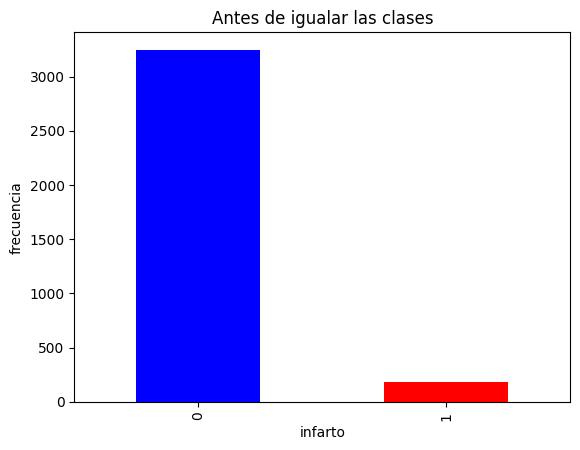

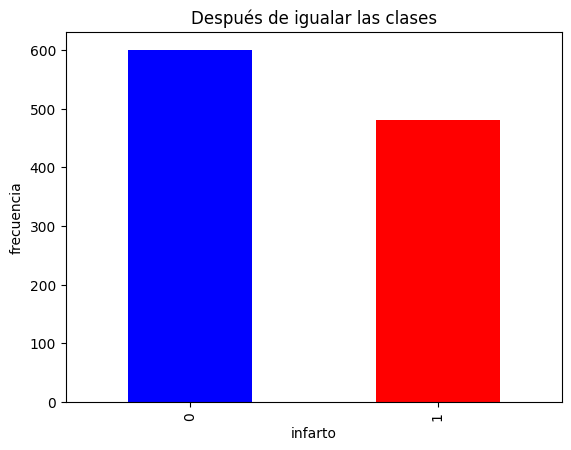

In [124]:
#HISTOGRAMA PARA VER LA DIFERENCIA DE CLASES 
data['infarto'].value_counts().plot(kind='bar', color=['blue', 'red'])
#añadir las etiquetas
plt.xlabel('infarto')
plt.ylabel('frecuencia')
plt.title('Antes de igualar las clases')
plt.show()

#igualar la cantidad de datos de cada clase
rus = RandomUnderSampler(random_state=2, sampling_strategy=0.3)
data = data.dropna()
X = data.drop(columns=['infarto'])
y = data['infarto']
X_resampled, y_resampled = rus.fit_resample(X, y)
data = pd.concat([X_resampled, y_resampled], axis=1)

ros = RandomOverSampler(random_state=2, sampling_strategy=0.8)
X = data.drop(columns=['infarto'])
y = data['infarto']
X_resampled, y_resampled = ros.fit_resample(X, y)
data = pd.concat([X_resampled, y_resampled], axis=1)


#mostar el histograma para ver la diferencia de clases
data['infarto'].value_counts().plot(kind='bar', color=['blue', 'red'])
#añadir las etiquetas
plt.title('Después de igualar las clases')
plt.xlabel('infarto')
plt.ylabel('frecuencia')
plt.show()



Convertir a numerica las categoricas, usamos labelencoder para las varibles binarias y onehotencoder para las multi variable.

In [125]:
# Instanciar el codificador para cada columna categórica
enc = OneHotEncoder()
label_enc = LabelEncoder()

# Codificar las columnas categóricas binarias
data['genero'] = label_enc.fit_transform(data['genero'])
data['casado'] = label_enc.fit_transform(data['casado'])
data['residencia'] = label_enc.fit_transform(data['residencia'])

# Selección de las columnas para la codificación
multi_categorical_columns = ['uso_tabaco', 'trabajo']


# Ajustar el encoder y transformar los datos
multi_categorical_encoded = enc.fit_transform(data[multi_categorical_columns])

multi_categorical_encoded_df = pd.DataFrame(multi_categorical_encoded.toarray(), columns=enc.get_feature_names_out(multi_categorical_columns))

# Resetear índices si se modificó 'data'
data.reset_index(drop=True, inplace=True)
multi_categorical_encoded_df.reset_index(drop=True, inplace=True)

# Concatenar los DataFrames
data = pd.concat([data.drop(multi_categorical_columns, axis=1), multi_categorical_encoded_df], axis=1)

# Normalizar todas las columnas con min-max
for column in data.columns:
    data[column] = (data[column] - data[column].min()) / (data[column].max() - data[column].min())






data.head(5)

,genero,edad,hipertensión,enfermedad_coronaria,casado,residencia,nivel_glucosa,bmi,infarto,uso_tabaco_Ex fumador,uso_tabaco_Fumador,uso_tabaco_Nunca,trabajo_Autonomo,trabajo_Funcionario,trabajo_Menor de edad,trabajo_Privado,trabajo_Sin trabajo
0,0.0,0.458333,0.0,0.0,1.0,1.0,0.197625,0.108818,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.652778,0.0,0.0,1.0,1.0,0.257647,0.307692,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,1.0,0.277778,0.0,0.0,0.0,1.0,0.154006,0.200750,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.583333,0.0,0.0,1.0,1.0,0.224933,0.264540,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.666667,0.0,0.0,1.0,1.0,0.188938,0.225141,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


In [126]:
# Dividir los datos en características y etiqueta
X = data.drop('infarto', axis=1)
y = data['infarto']

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#divir el train en train y validacion
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)





Creamos el modelo

In [127]:



class MLPClassifier:
    def __init__(self, input_dim, nl=1, nn=1, activation='relu', optimizer='adam', loss='mean_squared_error', learning_rate=0.01):
        self.input_dim = input_dim
        self.nl = nl  # Número de capas ocultas
        self.nn = nn  # Número de neuronas en cada capa oculta
        self.activation = activation
        self.optimizer = optimizer
        self.loss = loss
        self.learning_rate = learning_rate

    def create_model(self):
        model = Sequential()
        # Agregar la capa de entrada
        model.add(Dense(self.nn, input_dim=self.input_dim, activation=self.activation))
        
        # Agregar capas ocultas según el número especificado en nl
        for _ in range(self.nl - 1):  # nl incluye todas las capas ocultas
            model.add(Dense(self.nn, activation=self.activation))
        
        self.optimizer = Adam(learning_rate=self.learning_rate)
        
        # Agregar la capa de salida
        model.add(Dense(1, activation='sigmoid'))  # Usualmente para problemas de clasificación binaria usamos 'sigmoid'

        # Compilar el modelo
        model.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        return model
    


In [128]:

m = X_train.shape[0]
n_input = X_train.shape[1]

n_hidden_min = m / (2 * n_input)
n_hidden_max = (2 * m) / n_input

print("Numero de ejemplos de entrenamiento: ", m)
print("Numero de neuronas de la capa de entrada: ", n_input)
print("Rango mínimo de neuronas de la capa intermedia: ", n_hidden_min)
print("Rango máximo de neuronas de la capa intermedia: ", n_hidden_max)

n_hidden = int((n_hidden_min + n_hidden_max) / 2)
print("Número de neuronas de la capa intermedia elegido: ", n_hidden)

Numero de ejemplos de entrenamiento:  691
Numero de neuronas de la capa de entrada:  16
Rango mínimo de neuronas de la capa intermedia:  21.59375
Rango máximo de neuronas de la capa intermedia:  86.375
Número de neuronas de la capa intermedia elegido:  53


Epoch 1/100


c:\Users\alvar\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4482 - loss: 0.5021 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 2/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4667 - loss: 0.5333 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 3/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4808 - loss: 0.5192 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 4/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4579 - loss: 0.5421 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 5/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4687 - loss: 0.5313 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 6/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.4719 - loss: 0.5281 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 7/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4800 - loss: 0.5200 - val_accuracy: 0.4162 - val_loss: 0.5838
Epoch 8/100
22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4376 - loss: 0.5624 - val_accuracy: 0.4162 - val_loss: 0.5

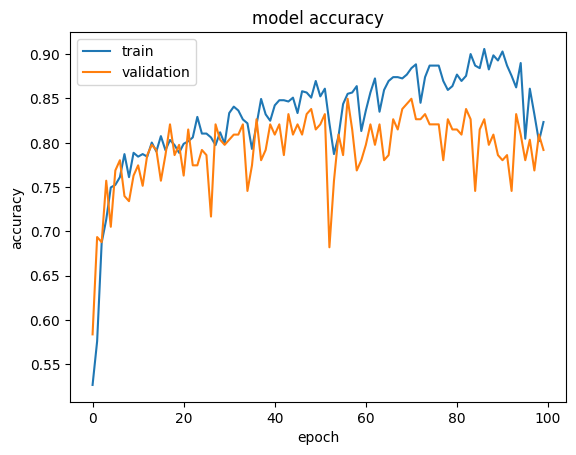

In [129]:
#hacer el gridsearch manualmente
# Definir el modelo
keras_model = MLPClassifier(input_dim=X_train.shape[1])


# Inicializar las variables para almacenar los resultados
best_score = 0
best_params = {}


param_grid = {
    'model__nl': [2, 5, 7],  # Número de capas ocultas
    'model__nn': [20, 70, 100],  # Número de neuronas por capa oculta
    'learning_rate': [0.5,0.1,0.01,]
}

# Realizar la búsqueda de hiperparámetros
for nl in param_grid['model__nl']:
    for nn in param_grid['model__nn']:
        for lr in param_grid['learning_rate']:
            keras_model = MLPClassifier(input_dim=X_train.shape[1], nl=nl, nn=nn, learning_rate=lr)
            model = keras_model.create_model()
            history= model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1, validation_data=(X_val, y_val))
            score = model.evaluate(X_test, y_test, verbose=1)
            if score[1] > best_score:
                best_score = score[1]
                best_params = {'nl': nl, 'nn': nn, 'lr': lr}

print('Mejor score:', best_score)
print('Mejores parámetros:', best_params)

#Mostrar la grafica de accuracy y loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Matriz de confusión

In [130]:
# Matrices de confusión para Train, Val, Test
y_pred_train = (model.predict(X_train) > 0.5).astype(int)
y_pred_val = (model.predict(X_val) > 0.5).astype(int)
y_pred_test = (model.predict(X_test) > 0.5).astype(int)

cm_train = confusion_matrix(y_train, y_pred_train)
cm_val = confusion_matrix(y_val, y_pred_val)
cm_test = confusion_matrix(y_test, y_pred_test)

print('Matriz de Confusión - Train:\n', cm_train)
print('Matriz de Confusión - Val:\n', cm_val)
print('Matriz de Confusión - Test:\n', cm_test)






22/22 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
Matriz de Confusión - Train:
 [[336  38]
 [ 63 254]]
Matriz de Confusión - Val:
 [[83 18]
 [18 54]]
Matriz de Confusión - Test:
 [[99 26]
 [26 65]]


In [131]:
#mostrar la tabla con la precisión, sensibilidad y especificidad del test y train
table = [['', 'Precisión', 'Sensibilidad', 'Especificidad'],
            ['Train', accuracy_score(y_train, y_pred_train), cm_train[0, 0] / (cm_train[0, 0] + cm_train[0, 1]), cm_train[1, 1] / (cm_train[1, 0] + cm_train[1, 1])],
            ['Val', accuracy_score(y_val, y_pred_val), cm_val[0, 0] / (cm_val[0, 0] + cm_val[0, 1]), cm_val[1, 1] / (cm_val[1, 0] + cm_val[1, 1])],
            ['Test', accuracy_score(y_test, y_pred_test), cm_test[0, 0] / (cm_test[0, 0] + cm_test[0, 1]), cm_test[1, 1] / (cm_test[1, 0] + cm_test[1, 1])]]

print(tabulate(table, headers='firstrow', tablefmt='fancy_grid'))



#Mostrar el accuracy del test
print('Accuracy del test:', accuracy_score(y_test, y_pred_test))

#Mostrar el accuracy del val
print('Accuracy del val:', accuracy_score(y_val, y_pred_val))

#Mostrar el accuracy del train
print('Accuracy del train:', accuracy_score(y_train, y_pred_train))






╒═══════╤═════════════╤════════════════╤═════════════════╕
│       │   Precisión │   Sensibilidad │   Especificidad │
╞═══════╪═════════════╪════════════════╪═════════════════╡
│ Train │    0.853835 │       0.898396 │        0.801262 │
├───────┼─────────────┼────────────────┼─────────────────┤
│ Val   │    0.791908 │       0.821782 │        0.75     │
├───────┼─────────────┼────────────────┼─────────────────┤
│ Test  │    0.759259 │       0.792    │        0.714286 │
╘═══════╧═════════════╧════════════════╧═════════════════╛
Accuracy del test: 0.7592592592592593
Accuracy del val: 0.791907514450867
Accuracy del train: 0.85383502170767


In [132]:
#Ver que variables influyen en que un paciente no tenga un infarto
importance = model.get_weights()[0]
importance = np.abs(importance)
importance = importance / importance.sum()
importance = importance * 100
importance = importance.flatten()
importance = importance[:X_train.shape[1]]
importance = pd.DataFrame(importance, index=X_train.columns, columns=['Importancia'])
importance = importance.sort_values(by='Importancia', ascending=False)
print(importance)






                       Importancia
uso_tabaco_Fumador        0.179984
bmi                       0.115775
genero                    0.077191
trabajo_Menor de edad     0.071166
trabajo_Funcionario       0.058886
trabajo_Privado           0.052640
enfermedad_coronaria      0.048412
uso_tabaco_Nunca          0.045570
hipertensión              0.038134
uso_tabaco_Ex fumador     0.024508
trabajo_Autonomo          0.021952
residencia                0.017746
edad                      0.006336
casado                    0.004402
nivel_glucosa             0.001288
trabajo_Sin trabajo       0.000169
